In [2]:
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import models, transforms
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

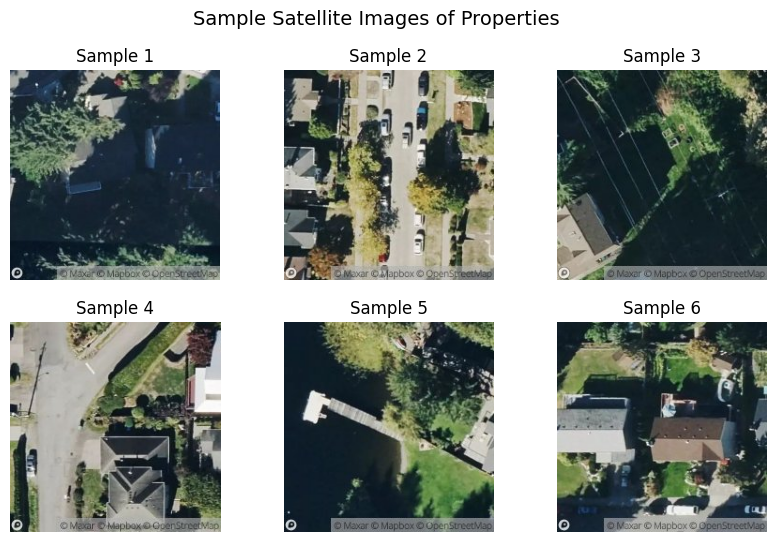

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

img_dir = "images/train"
sample_imgs = random.sample(os.listdir(img_dir), 6)

plt.figure(figsize=(10,6))
for i, img_name in enumerate(sample_imgs):
    img = Image.open(os.path.join(img_dir, img_name))
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Sample {i+1}")

plt.suptitle("Sample Satellite Images of Properties", fontsize=14)
plt.show()

In [4]:
df=pd.read_csv("df_with_residuals.csv")

In [5]:
import cv2
import numpy as np
image_dir = "images/train"

def green_ratio_hsv(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    h, s, v = cv2.split(img)

    # Green color range in HSV
    green_mask = (
        (h >= 35) & (h <= 85) &   # green hues
        (s >= 40) &               # avoid gray
        (v >= 40)                 # avoid shadows
    )

    return np.mean(green_mask)


In [6]:
green_scores = []

for img_id in df["id"]:
    path = os.path.join(image_dir, str(img_id) + ".png")
    green_scores.append(green_ratio_hsv(path))

green_scores = np.array(green_scores)

In [7]:
def urban_ratio(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128,128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    h, s, v = cv2.split(img)

    # Low saturation + medium brightness = concrete / roads
    urban_mask = (s < 40) & (v > 50)

    return np.mean(urban_mask)

In [8]:
urban_scores = []

for img_id in df["id"]:
    path = os.path.join(image_dir, str(img_id) + ".png")
    urban_scores.append(urban_ratio(path))

urban_scores = np.array(urban_scores)

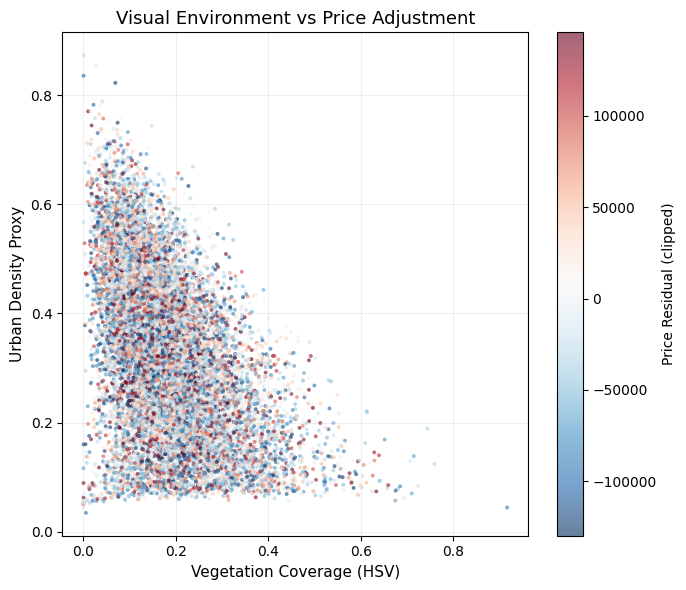

In [9]:
plt.figure(figsize=(7,6))

res_clip = np.clip(
    df['residuals'],
    np.percentile(df['residuals'], 5),
    np.percentile(df['residuals'], 95)
)

plt.scatter(
    green_scores,
    urban_scores,
    c=res_clip,
    cmap="RdBu_r",
    s=8,
    alpha=0.6,
    linewidths=0
)

plt.xlabel("Vegetation Coverage (HSV)", fontsize=11)
plt.ylabel("Urban Density Proxy", fontsize=11)
plt.title("Visual Environment vs Price Adjustment", fontsize=13)

cbar = plt.colorbar()
cbar.set_label("Price Residual (clipped)", fontsize=10)

plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()



Both positive and negative price adjustments are observed across visual environments. Blue points indicate cases where satellite imagery suggests a lower valuation than what tabular features alone would predict. This commonly occurs in dense urban areas, regions with limited accessibility, or visually less desirable neighborhoods that are not fully captured by structured data. The presence of both positive and negative adjustments highlights that the image model acts as a corrective signal rather than a one-sided booster.

In [10]:
RESIDUAL_THRESHOLD = df['residuals'].abs().quantile(0.69)

hard_df = df[df['residuals'].abs() >= RESIDUAL_THRESHOLD].reset_index(drop=True)

print(f"Using {len(hard_df)} hard samples out of {len(df)}")


Using 5025 hard samples out of 16209


In [11]:
train_df, val_df = train_test_split(
    hard_df,
    test_size=0.2,
    random_state=42
)

In [12]:
class ImageOnlyDataset(Dataset):
    def __init__(self, df, image_dir):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_path = os.path.join(self.image_dir, f"{row['id']}.png")

        assert os.path.exists(img_path), f"Missing image for ID {row['id']}"

        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        return image

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet.fc = nn.Identity()   # output = 512-d embedding
resnet = resnet.to(device)
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
def extract_embeddings(df, image_dir):
    dataset = ImageOnlyDataset(df, image_dir)
    loader = DataLoader(
        dataset,
        batch_size=32,
        shuffle=False,   # IMPORTANT: preserve row order
        num_workers=0
    )

    embeddings = []

    with torch.no_grad():
        for imgs in loader:
            imgs = imgs.to(device)
            emb = resnet(imgs)
            embeddings.append(emb.cpu())

    return torch.cat(embeddings).numpy()

In [15]:
X_train_img = extract_embeddings(train_df, "images/train")

X_val_img   = extract_embeddings(val_df, "images/train")



y_train = train_df['residuals'].values
y_val   = val_df['residuals'].values


In [16]:
from sklearn.linear_model import ElasticNet

residual_model = ElasticNet(
    alpha=1.0,
    l1_ratio=0.3,
    max_iter=5000
)


residual_model.fit(X_train_img, y_train)


val_residual_preds = residual_model.predict(X_val_img)

In [17]:
final_preds = val_df['lgb_pred'].values + val_residual_preds
true_prices = val_df['lgb_pred'].values + val_df['residuals'].values

print("FINAL RMSE:",
      np.sqrt(mean_squared_error(true_prices, final_preds)))

print("FINAL R²:",
      r2_score(true_prices, final_preds))

FINAL RMSE: 167082.82207999966
FINAL R²: 0.894810249784694


**(Tabular + Image)data trained model with R2 score of 0.8948, improvement from 0.855 (just tabular data)**

In [18]:
import joblib
joblib.dump(residual_model, "image_residual_model.pkl")

['image_residual_model.pkl']